#Capstone Project Machine Learning Model
Faiz Khansa Adrika M0080838

##Import and list dependencies

In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import numpy as np
from google.colab import files
from keras.preprocessing.image import load_img, img_to_array

In [ ]:
data_dir = '/content/drive/MyDrive/dataset'
train_dir = '/content/drive/MyDrive/dataset/train'
val_dir = '/content/drive/MyDrive/dataset/test'

##Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(130, 130),
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(130, 130),
        class_mode='categorical')

Found 714 images belonging to 4 classes.
Found 177 images belonging to 4 classes.


##Modelling and Training

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),padding ='same',strides=(2,2),activation='relu',input_shape=(130,130,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),padding ='same',strides=(2,2),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),padding ='same',strides=(2,2),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128,(3,3),padding ='same',strides=(2,2),activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 65, 65, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 128)         7

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
 #tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.89):
      print("\nReached 89% accuracy")
      self.model.stop_training = True
callback = myCallback()

In [ ]:
history = model.fit(train_generator, 
                    epochs=100, 
                    validation_data = test_generator,
                    callbacks = [callback])

Epoch 1/100
23/23 [==============================] - 17s 724ms/step - loss: 1.3781 - accuracy: 0.3081 - val_loss: 1.3556 - val_accuracy: 0.2373
Epoch 2/100
23/23 [==============================] - 16s 709ms/step - loss: 1.3002 - accuracy: 0.3739 - val_loss: 1.0528 - val_accuracy: 0.4972
Epoch 3/100
23/23 [==============================] - 16s 710ms/step - loss: 1.0137 - accuracy: 0.5490 - val_loss: 0.9016 - val_accuracy: 0.6215
Epoch 4/100
23/23 [==============================] - 16s 713ms/step - loss: 0.9554 - accuracy: 0.6078 - val_loss: 0.8439 - val_accuracy: 0.6780
Epoch 5/100
23/23 [==============================] - 16s 656ms/step - loss: 0.8122 - accuracy: 0.6513 - val_loss: 0.7369 - val_accuracy: 0.7062
Epoch 6/100
23/23 [==============================] - 16s 691ms/step - loss: 0.8116 - accuracy: 0.6681 - val_loss: 0.7712 - val_accuracy: 0.7288
Epoch 7/100
23/23 [==============================] - 16s 682ms/step - loss: 0.7222 - accuracy: 0.7073 - val_loss: 0.6638 - val_accuracy:

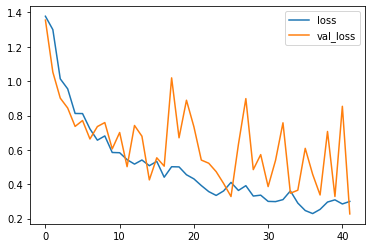

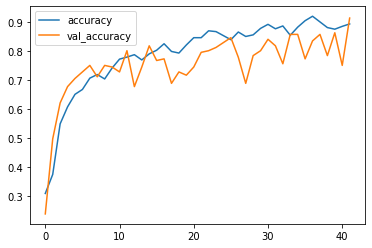

In [ ]:
import pandas as pd
histories = pd.DataFrame(model.history.history)
histories[["loss", "val_loss"]].plot()
histories[["accuracy", "val_accuracy"]].plot()

##Save and convert the model to the required formats

Convert to TFLITE

In [ ]:
saved_model = 'saved_model'
tf.saved_model.save(model, saved_model)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: saved_model/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

tflite_model_file = 'converted_model.tflite'
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [ ]:
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

Freeze and Save the model files to Drive

In [ ]:
model.save('/content/drive/MyDrive/Caps')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Caps/assets


Convert as JSON

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

Convert as YAML

In [ ]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

##Predict using the TFLITE model

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  img = load_img(fn, target_size=(130, 130))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  images = np.vstack([img])
  classes=[]
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  classes.append(interpreter.get_tensor(output_index))
  if classes[0][0][0]==1:
    print(fn+" is Damaged road(pothole)")
  elif classes[0][0][1]==1:
    print(fn+" is Flooded road")
  elif classes[0][0][2]==1:
    print(fn+" is Good road")
  else:
    print(fn+' is Traffic Jam')
  classes.clear()

Saving verypoor_042.jpg to verypoor_042 (1).jpg
verypoor_042.jpg is Traffic Jam


In [ ]:
train_generator.class_indices

{'damaged': 0, 'flood': 1, 'good': 2, 'jam': 3}

In [ ]:
test_generator.class_indices

{'damaged': 0, 'flood': 1, 'good': 2, 'jam': 3}